In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook determines an e-distance for each perturbation relative to control cells to (relatively) quantify their magnitude ###

import h5py
import numpy as np
import pandas as pd
import nexusformat.nexus as nx
import tables
import scipy
import scanpy as sc
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as pl
import math
%load_ext rpy2.ipython

# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.2.2 
2: package ‘datasets’ was built under R version 4.2.2 
3: package ‘utils’ was built under R version 4.2.2 
4: package ‘grDevices’ was built under R version 4.2.2 
5: package ‘graphics’ was built under R version 4.2.2 
6: package ‘stats’ was built under R version 4.2.2 


In [2]:
### things to vary to get better p-values and non-negative distances

## the control guide which things are assessed relative to (spend time picking good controls)
## assess # of control cells vs pertuabtion cells and vary the number of sampled cells in class imbalance
## look how big the radius of perturbation and control is in PC space and cutoff # of PCs used in dist calculation
## lower max variable features during to 500?


In [2]:
## Load in data ##
adata = sc.read('/home/ssobti/projects/mir_tud/010523_filtered_data/miR.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.h5ad')

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


In [3]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   
...                             ...         ...           ...    ...   
miR_3:TTTGGTTTCGGACTTA-1        miR     25937.0          5525  miR_3   
miR_3:TTTGTTGCACGCGTGT-1        miR     82115.0          8826  miR_3   
miR_3:TTTGTTGCATAGATCC-1        miR     34833.0          6430  miR_3   
miR_3:TTTGTTGGTCTAGTGT-1        miR     22318.0          5103  miR_3   
miR_3:TTTGTTGGTTTCCATT-1        miR     19834.0          5082  miR_3   

                                   barcode             guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC   hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT     hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT   hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA         TuD_NC_18  5.859895   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT   hsa-miR-147b-5p  5.632808   
...                                    ...               ...       ...   
miR_3:TTTGGTTTCGGACTTA-1  TTTGGTTTCGGACTTA    hsa-miR-616-5p  3.885564   
miR_3:TTTGTTGCACGCGTGT-1  TTTGTTGCACGCGTGT    hsa-miR-361-5p  0.506602   
miR_3:TTTGTTGCATAGATCC-1  TTTGTTGCATAGATCC   hsa-miR-548o-3p  6.603449   
miR_3:TTTGTTGGTCTAGTGT-1  TTTGTTGGTCTAGTGT   hsa-miR-3940-5p  2.402414   
miR_3:TTTGTTGGTTTCCATT-1  TTTGTTGGTTTCCATT  hsa-miR-10527-5p  6.014592   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0  ...   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  ...   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  ...   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  ...   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0  ...   
...                                 ...            ...      ...  ...   
miR_3:TTTGGTTTCGGACTTA-1  8.005527e-277  6.410418e-270    129.0  ...   
miR_3:TTTGTTGCACGCGTGT-1   8.834341e-07   1.000000e+00      2.0  ...   
miR_3:TTTGTTGCATAGATCC-1  5.795787e-306  4.640971e-299    126.0  ...   
miR_3:TTTGTTGGTCTAGTGT-1  5.349572e-125  4.283664e-118     58.0  ...   
miR_3:TTTGTTGGTTTCCATT-1  4.169835e-209  3.338991e-202    101.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   
...                            ...        ...          ...        ...   
miR_3:TTTGGTTTCGGACTTA-1  0.596977  44.983627     2.110590   2.374748   
miR_3:TTTGTTGCACGCGTGT-1  0.030227   0.034438     0.301030   1.079181   
miR_3:TTTGTTGCATAGATCC-1  0.400504  40.028586     2.100371   2.201397   
miR_3:TTTGTTGGTCTAGTGT-1  0.277078   9.251317     1.763428   2.041393   
miR_3:TTTGTTGGTTTCCATT-1  0.329975  25.736801     2.004321   2.117271   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   
...                             ...         ...                     ...   
miR_

In [4]:
#meta data prior to filtering
meta = adata.obs
meta['guide'] = meta['guide'].astype('string')
meta.loc[meta.loc[:,'guide'].str.startswith('TuD'), 'guide'] = 'TuD_NC'
meta['guide'] = meta['guide'].astype('category')
meta.dtypes

orig.ident                  object
nCount_RNA                 float64
nFeature_RNA                 int32
sample                      object
barcode                     object
guide                     category
lor                        float64
pvalue                     float64
adj_pvalue                 float64
max_umi                    float64
n_umi                      float64
m_umi                      float64
v_umi                      float64
log_max_umi                float64
log_n_umi                  float64
log_m_umi                  float64
percent.mt                 float64
integrated_snn_res.0.5       int32
seurat_clusters             object
guide_group                 object
miR.family                  object
dtype: object

In [5]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   
...                             ...         ...           ...    ...   
miR_3:TTTGGTTTCGGACTTA-1        miR     25937.0          5525  miR_3   
miR_3:TTTGTTGCACGCGTGT-1        miR     82115.0          8826  miR_3   
miR_3:TTTGTTGCATAGATCC-1        miR     34833.0          6430  miR_3   
miR_3:TTTGTTGGTCTAGTGT-1        miR     22318.0          5103  miR_3   
miR_3:TTTGTTGGTTTCCATT-1        miR     19834.0          5082  miR_3   

                                   barcode             guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC   hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT     hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT   hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA            TuD_NC  5.859895   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT   hsa-miR-147b-5p  5.632808   
...                                    ...               ...       ...   
miR_3:TTTGGTTTCGGACTTA-1  TTTGGTTTCGGACTTA    hsa-miR-616-5p  3.885564   
miR_3:TTTGTTGCACGCGTGT-1  TTTGTTGCACGCGTGT    hsa-miR-361-5p  0.506602   
miR_3:TTTGTTGCATAGATCC-1  TTTGTTGCATAGATCC   hsa-miR-548o-3p  6.603449   
miR_3:TTTGTTGGTCTAGTGT-1  TTTGTTGGTCTAGTGT   hsa-miR-3940-5p  2.402414   
miR_3:TTTGTTGGTTTCCATT-1  TTTGTTGGTTTCCATT  hsa-miR-10527-5p  6.014592   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0  ...   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  ...   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  ...   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  ...   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0  ...   
...                                 ...            ...      ...  ...   
miR_3:TTTGGTTTCGGACTTA-1  8.005527e-277  6.410418e-270    129.0  ...   
miR_3:TTTGTTGCACGCGTGT-1   8.834341e-07   1.000000e+00      2.0  ...   
miR_3:TTTGTTGCATAGATCC-1  5.795787e-306  4.640971e-299    126.0  ...   
miR_3:TTTGTTGGTCTAGTGT-1  5.349572e-125  4.283664e-118     58.0  ...   
miR_3:TTTGTTGGTTTCCATT-1  4.169835e-209  3.338991e-202    101.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   
...                            ...        ...          ...        ...   
miR_3:TTTGGTTTCGGACTTA-1  0.596977  44.983627     2.110590   2.374748   
miR_3:TTTGTTGCACGCGTGT-1  0.030227   0.034438     0.301030   1.079181   
miR_3:TTTGTTGCATAGATCC-1  0.400504  40.028586     2.100371   2.201397   
miR_3:TTTGTTGGTCTAGTGT-1  0.277078   9.251317     1.763428   2.041393   
miR_3:TTTGTTGGTTTCCATT-1  0.329975  25.736801     2.004321   2.117271   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   
...                             ...         ...                     ...   
miR_

In [6]:
count_df = meta.groupby(by = ['guide']).size().reset_index(name = 'cells')
idxs = count_df.loc[:,'guide'].str.startswith('TuD')
guide_type = ['control' if x is True else 'perturbation' for x in idxs]
count_df['type'] = guide_type
count_df

guide  cells          type
0               TuD_NC   3101       control
1     hsa-miR-10399-3p     81  perturbation
2     hsa-miR-10399-5p     67  perturbation
3     hsa-miR-10401-3p     45  perturbation
4     hsa-miR-10523-5p    107  perturbation
..                 ...    ...           ...
331         miR-942-5p     57  perturbation
332          miR-95-3p     45  perturbation
333  miR-96-5p/1271-5p    158  perturbation
334          miR-99-3p     71  perturbation
335   miR-99-5p/100-5p     98  perturbation

[336 rows x 3 columns]

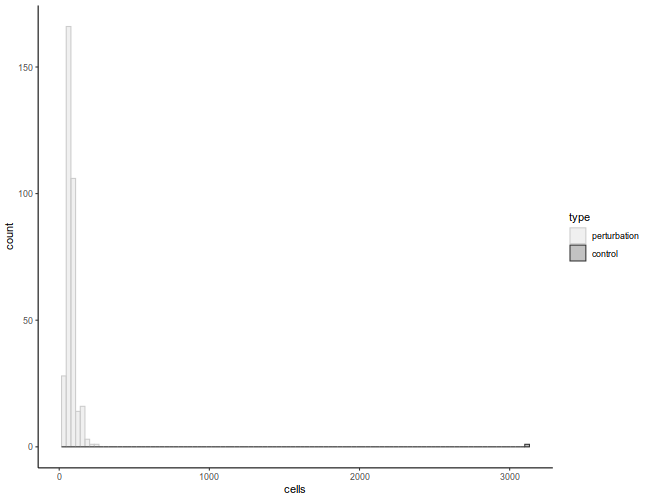

In [7]:
%%R -i count_df -w 650 -h 500
### data exploration of cells per perturbation with histogram

library(ggplot2)
count_df2 = count_df[!count_df$guide == 'TuD_NC_01',]
count_df2$type <- factor(count_df2$type, levels = c('perturbation', 'control'))

## without TuD_NC_01 which has 1687 cells
ggplot(count_df2, aes(x = cells, fill = type, color = type)) + 
geom_histogram(position = "identity", alpha = 0.3, bins = 100) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) + theme_classic()

In [8]:
adata.obs = meta
adata.obs.head()

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   

                                   barcode                     guide  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC             miR-203a-3p.1   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT                 miR-93-3p   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT  miR-130-3p/301-3p/454-3p   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA                    TuD_NC   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT                  miR-147b   

                               lor         pvalue     adj_pvalue  max_umi  \
miR_1:AAACCCAAGGAGAGGC-1  5.453121  2.983000e-159  3.010603e-152     67.0   
miR_1:AAACCCAAGGTAAACT-1  6.012001  3.907611e-225  3.943769e-218     97.0   
miR_1:AAACCCACAACGATCT-1  5.864701  3.299362e-202  3.329893e-195     89.0   
miR_1:AAACCCACACGATTCA-1  5.859895  2.574602e-201  2.598426e-194     96.0   
miR_1:AAACCCACAGTCAACT-1  5.632808  3.564463e-178  3.597446e-171     71.0   

                          ...     m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  ...  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  ...  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  ...  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  ...  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  ...  0.216625  12.725683     1.851258   1.934498   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   

                          seurat_clusters guide_group  \
miR_1:AAACCCAAGGAGAGGC-1               T2      target   
miR_1:AAACCCAAGGTAAACT-1               T0      target   
miR_1:AAACCCACAACGATCT-1               T0      target   
miR_1:AAACCCACACGATTCA-1          control     control   
miR_1:AAACCCACAGTCAACT-1               T8      target   

                                        miR.family  
miR_1:AAACCCAAGGAGAGGC-1             miR-203a-3p.1  
miR_1:AAACCCAAGGTAAACT-1                 miR-93-3p  
miR_1:AAACCCACAACGATCT-1  miR-130-3p/301-3p/454-3p  
miR_1:AAACCCACACGATTCA-1                        NA  
miR_1:AAACCCACAGTCAACT-1                  miR-147b  

[5 rows x 21 columns]

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


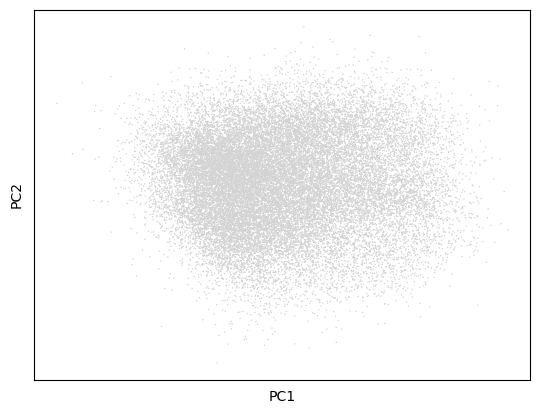

In [9]:
sc.pl.pca(adata)

In [10]:
# high class imbalance
adata = equal_subsampling(adata, 'guide', N_min=50)

In [11]:
adata.uns['processed'] = True

In [12]:
#meta data post-filtering
meta = adata.obs
meta

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:GACCTTCTCTTGCAAG-1        miR     43673.0          7535  miR_1   
miR_2:CTGAATGCAGCTGTGC-1        miR     20305.0          5453  miR_2   
miR_2:CCACGTTGTTGGTAGG-1        miR     72601.0          8726  miR_2   
miR_3:TGCAGGCAGTTCACTG-1        miR     56819.0          8345  miR_3   
miR_1:CATGAGTTCGAGCCTG-1        miR     51701.0          7990  miR_1   
...                             ...         ...           ...    ...   
miR_1:GGGACCTTCCAATCCC-1        miR     56217.0          8087  miR_1   
miR_2:TGGATGTTCTCCTGCA-1        miR     36697.0          6379  miR_2   
miR_1:CTACCTGTCGACGAGA-1        miR     42605.0          7583  miR_1   
miR_2:AGGATAATCGCAGTTA-1        miR     38137.0          6405  miR_2   
miR_3:GTGTGGCGTTCCATTT-1        miR     41018.0          6863  miR_3   

                                   barcode        guide       lor  \
miR_1:GACCTTCTCTTGCAAG-1  GACCTTCTCTTGCAAG       TuD_NC  6.635950   
miR_2:CTGAATGCAGCTGTGC-1  CTGAATGCAGCTGTGC       TuD_NC  1.121474   
miR_2:CCACGTTGTTGGTAGG-1  CCACGTTGTTGGTAGG       TuD_NC  4.885842   
miR_3:TGCAGGCAGTTCACTG-1  TGCAGGCAGTTCACTG       TuD_NC  3.509584   
miR_1:CATGAGTTCGAGCCTG-1  CATGAGTTCGAGCCTG       TuD_NC  6.218424   
...                                    ...          ...       ...   
miR_1:GGGACCTTCCAATCCC-1  GGGACCTTCCAATCCC  miR-4742-3p  5.791977   
miR_2:TGGATGTTCTCCTGCA-1  TGGATGTTCTCCTGCA  miR-4742-3p  6.664280   
miR_1:CTACCTGTCGACGAGA-1  CTACCTGTCGACGAGA  miR-4742-3p  6.074720   
miR_2:AGGATAATCGCAGTTA-1  AGGATAATCGCAGTTA  miR-4742-3p  6.441211   
miR_3:GTGTGGCGTTCCATTT-1  GTGTGGCGTTCCATTT  miR-4742-3p  3.380534   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:GACCTTCTCTTGCAAG-1  4.940656e-324  4.986374e-317    171.0  ...   
miR_2:CTGAATGCAGCTGTGC-1   3.714397e-24   3.865853e-17     24.0  ...   
miR_2:CCACGTTGTTGGTAGG-1  4.940656e-324  5.142113e-317    157.0  ...   
miR_3:TGCAGGCAGTTCACTG-1   1.264197e-38   1.012305e-31     39.0  ...   
miR_1:CATGAGTTCGAGCCTG-1  2.465004e-237  2.487814e-230    204.0  ...   
...                                 ...            ...      ...  ...   
miR_1:GGGACCTTCCAATCCC-1  4.940656e-324  4.986374e-317    213.0  ...   
miR_2:TGGATGTTCTCCTGCA-1  1.162270e-279  1.209662e-272    116.0  ...   
miR_1:CTACCTGTCGACGAGA-1  3.922608e-230  3.958905e-223     95.0  ...   
miR_2:AGGATAATCGCAGTTA-1  4.940656e-324  5.142113e-317    135.0  ...   
miR_3:GTGTGGCGTTCCATTT-1  3.889817e-282  3.114767e-275    120.0  ...   

                             m_umi       v_umi  log_max_umi  log_n_umi  \
miR_1:GACCTTCTCTTGCAAG-1  0.586902   73.677404     2.232996   2.367356   
miR_2:CTGAATGCAGCTGTGC-1  0.146096    1.635168     1.380211   1.763428   
miR_2:CCACGTTGTTGGTAGG-1  0.634761   62.353637     2.195900   2.401401   
miR_3:TGCAGGCAGTTCACTG-1  0.259446    3.960296     1.591065   2.012837   
miR_1:CATGAGTTCGAGCCTG-1  0.730479  104.874144     2.309630   2.462398   
...                            ...         ...          ...        ...   
miR_1:GGGACCTTCCAATCCC-1  0.664987  114.374857     2.328380   2.421604   
miR_2:TGGATGTTCTCCTGCA-1  0.397985   33.947269     2.064458   2.198657   
miR_1:CTACCTGTCGACGAGA-1  0.322418   22.779622     1.977724   2.107210   
miR_2:AGGATAATCGCAGTTA-1  0.460957   45.976376     2.130334   2.262451   
miR_3:GTGTGGCGTTCCATTT-1  0.448363   37.283312     2.079181   2.250420   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:GACCTTCTCTTGCAAG-1  -0.231435    4.767247                       3   
miR_2:CTGAATGCAGCTGTGC-1  -0.835363    7.618813                       5   
miR_2:CCACGTTGTTGGTAGG-1  -0.197390    6.728557                       6   
miR_3:TGCAGGCAGTTCACTG-1  -0.585953    8.083564                       1   
miR_1:CATGAGTTCGAGCCTG-1  -0.136393    6.108199                       0   
...                             ...         ...                     ...   
miR_1:GGGACCTTCCAATCCC-1  -0.177187    4.534216     

# E-distance

In [13]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'guide', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████| 300/300 [02:34<00:00,  1.94it/s]


In [14]:
# Compute E-distances
estats = edist(adata, obs_key='guide', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [15]:
# square matrix, all pairs of perturbations get an e-distance
estats.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_estats_mtx_combined_controls_without_miR_families.csv')
estats.head()

TuD_NC  miR-34-5p/449-5p  \
TuD_NC                     0.000000         20.001256   
miR-34-5p/449-5p          20.001256          0.000000   
miR-130-3p/301-3p/454-3p   6.332734         16.507185   
miR-28-5p/708-5p           4.354515         16.821020   
miR-183-3p                -5.421016         17.097595   

                          miR-130-3p/301-3p/454-3p  miR-28-5p/708-5p  \
TuD_NC                                    6.332734          4.354515   
miR-34-5p/449-5p                         16.507185         16.821020   
miR-130-3p/301-3p/454-3p                  0.000000         -7.959005   
miR-28-5p/708-5p                         -7.959005          0.000000   
miR-183-3p                                5.974112        -10.074325   

                          miR-183-3p  miR-641/3617-5p  miR-30c-3p/6788-5p  \
TuD_NC                     -5.421016        19.800993          -19.260418   
miR-34-5p/449-5p           17.097595         5.758502           16.313949   
miR-130-3p/301-3p/454-3p    5.974112        17.150724           12.800413   
miR-28-5p/708-5p          -10.074325        26.803823           16.176637   
miR-183-3p                  0.000000        28.405100            2.220604   

                          let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p  \
TuD_NC                                                -9.599270   
miR-34-5p/449-5p                                       4.166045   
miR-130-3p/301-3p/454-3p                              -3.105913   
miR-28-5p/708-5p                                     -13.901358   
miR-183-3p                                           -13.034736   

                          miR-15-5p/16-5p/195-5p/424-5p/497-5p  miR-146-5p  \
TuD_NC                                                7.303788  -13.148515   
miR-34-5p/449-5p                                     12.957435    1.969506   
miR-130-3p/301-3p/454-3p                             -5.650469   -4.597609   
miR-28-5p/708-5p                                      1.458093   -5.825379   
miR-183-3p                                           15.818580  -11.510287   

                          ...  miR-624-5p  miR-877-3p   miR-1248  miR-339-5p  \
TuD_NC                    ...  -13.138056    4.701344 -11.318957  -19.599961   
miR-34-5p/449-5p          ...  -11.337165   18.794700  11.365313    6.675822   
miR-130-3p/301-3p/454-3p  ...   -0.956676   -2.750821  -4.484734    2.790232   
miR-28-5p/708-5p          ...    8.456415  -21.478405  -8.959530    0.494660   
miR-183-3p                ...    0.529032   -2.033698  -4.628142   -5.242069   

                          let-7f-2-3p/1185-3p  miR-196-5p  miR-33-5p  \
TuD_NC                              -3.610364   -5.364796   4.842312   
miR-34-5p/449-5p                    -9.364756   -5.928002  20.392846   
miR-130-3p/301-3p/454-3p            -7.222104   -6.707177   9.919950   
miR-28-5p/708-5p                     6.726202    2.574467   7.238575   
miR-183-3p                           5.180505    6.140224  18.490815   

                          miR-191-5p  miR-660-5p  miR-4742-3p  
TuD_NC                    -13.268134   -5.289327    -5.729413  
miR-34-5p/449-5p           16.346613   59.416604     1.269916  
miR-130-3p/301-3p/454-3p    3.602466   13.107793    -8.496023  
miR-28-5p/708-5p            3.956970   10.532399     5.902150  
miR-183-3p                  3.575593   -4.048873     3.631077  

[5 rows x 300 columns]

E-distance relative to control KD (plotted better in R below)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


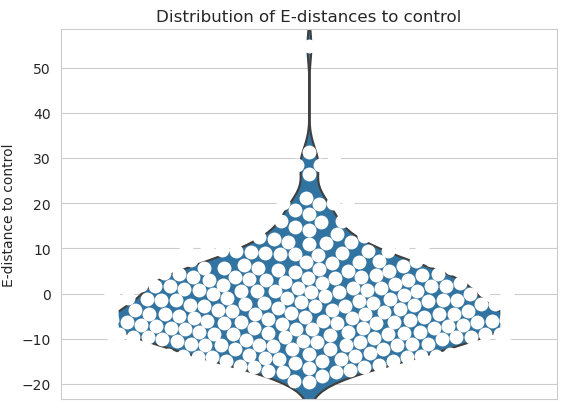

In [16]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['TuD_NC'], inner=None)
    sns.swarmplot(data=estats.loc['TuD_NC'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




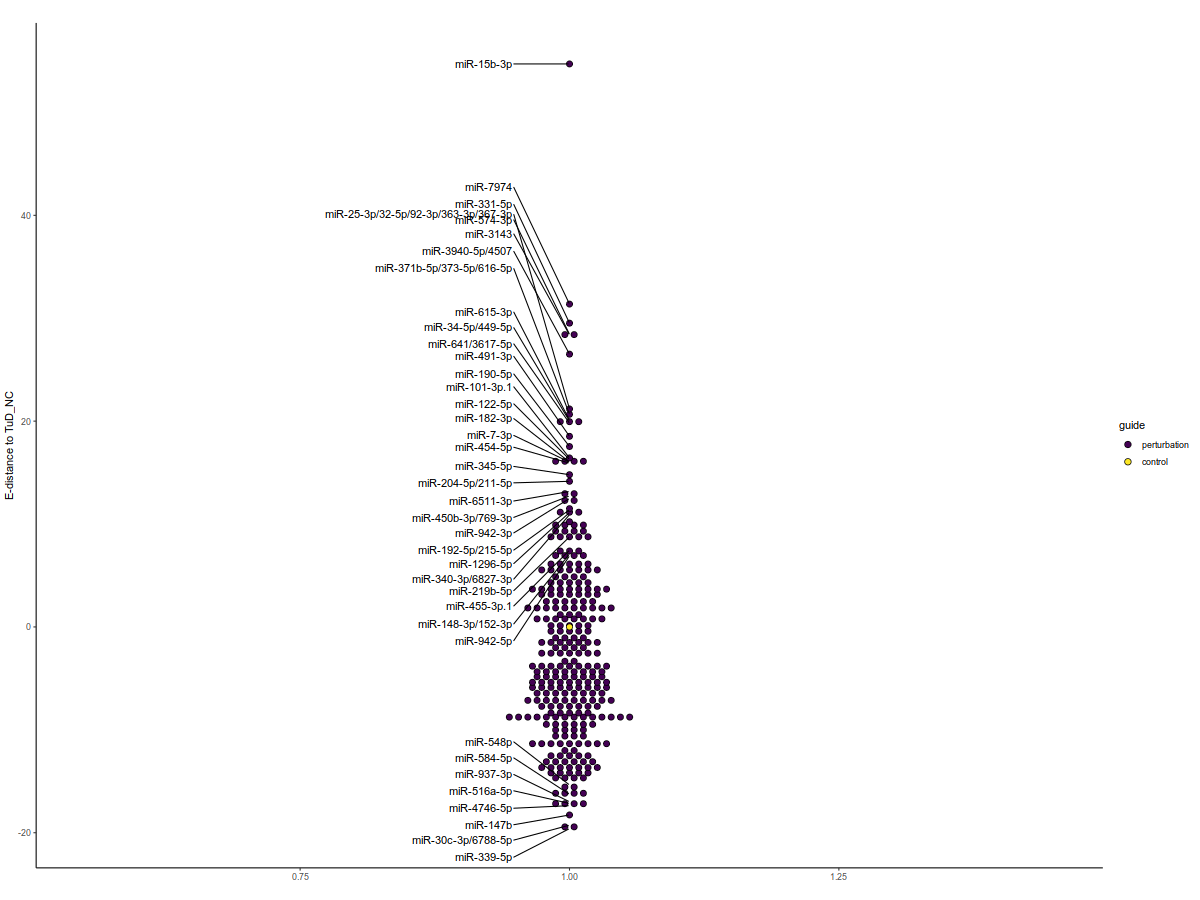

In [17]:
%%R -i estats -w 1200 -h 900
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(dplyr)

## draw barplots showing distances of the perturbations to each of the controls
## capture top 20% furthest guides from each of the controls


startsWith(colnames(estats), prefix = 'TuD') -> status
control_status = 1:length(status)
control_status[status] <- 'control'
control_status[!status] <- 'perturbation'
estats_control1 <- data.frame(comparison_to_control_NC1 = estats[,'TuD_NC'], guide = control_status, guide_nm = rownames(estats))
estats_control1 <- estats_control1[order(estats_control1$guide, decreasing = TRUE),]
estats_control1$guide <- factor(estats_control1$guide, levels = c('perturbation', 'control'))
tp20_pct <- as.character(estats_control1[order(estats_control1$comparison_to_control_NC1, decreasing = TRUE),"guide_nm"][1:ceiling(0.2*nrow(estats_control1))])
dotplot = ggplot(estats_control1, aes(x = 1, y=comparison_to_control_NC1, fill = guide)) + 
    geom_dotplot(binaxis='y', stackdir='center',
                 stackratio=1.5, dotsize=1.2, binwidth = 0.5) + scale_fill_viridis_d() + 
    geom_text_repel(aes(y = comparison_to_control_NC1, x = 1, label = guide_nm),
                    xlim = c(0, 0.95), 
                    direction = "y") +
    theme_classic() + ylab('E-distance to TuD_NC') + xlab('') + ggtitle('')

dotplot

Heatmap of pariwise E-distances of perturbations to each other

In [18]:
## in this heatmap a lighter color means a perturbation is further away from another perturbation
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100])
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_combined_controls_without_miR_families.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [19]:
## better color scheme
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100], cmap="vlag", vmin = -10, vmax = 10, cbar_kws={"ticks":[-10, -5,  0, 5,  10]})
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_color2_combined_controls_without_miR_families.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# E-testing (p-value calculation)

In [20]:
# e-testing (slow) -- here's what it's doing based on the paper:
## pvalue is found by combining the control cells and pertubation cells and switching their control/perturbation labels
## randomly 100 times to see how many times one gets a distance larger than when using the true original labels
## p-values are then adjusted using the Holm-Sidak method for multiple comparisons
df = etest(adata, obs_key='guide', obsm_key='X_pca', dist='sqeuclidean', control='TuD_NC', alpha=0.05, runs=100)

100%|██████████| 100/100 [12:25<00:00,  7.46s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [21]:
## convert all distances to z-scores,
## then find new pvalue_adj by summing the z


In [22]:
df.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_df_combined_controls_without_miR_families.csv')
df.sort_values('pvalue_adj')

edist  pvalue  significant  pvalue_adj  \
TuD_NC                      0.000000    0.00         True    0.000000   
miR-15b-3p                 54.715516    0.00         True    0.000000   
miR-34-5p/449-5p           20.001256    0.03         True    0.999886   
miR-331-5p                 29.524625    0.04         True    0.999995   
miR-371b-5p/373-5p/616-5p  20.664671    0.05        False    1.000000   
...                              ...     ...          ...         ...   
miR-199-3p                -13.444737    0.94        False    1.000000   
miR-197-3p                  8.760557    0.23        False    1.000000   
miR-196-5p                 -5.364796    0.63        False    1.000000   
miR-219b-5p                 8.752170    0.16        False    1.000000   
miR-99-5p/100-5p          -10.243432    0.81        False    1.000000   

                           significant_adj  
TuD_NC                                True  
miR-15b-3p                            True  
miR-34-5p/449-5p                     False  
miR-331-5p                           False  
miR-371b-5p/373-5p/616-5p            False  
...                                    ...  
miR-199-3p                           False  
miR-197-3p                           False  
miR-196-5p                           False  
miR-219b-5p                          False  
miR-99-5p/100-5p                     False  

[300 rows x 5 columns]

In [23]:
df.sort_values('pvalue')

edist  pvalue  significant  \
TuD_NC                                0.000000    0.00         True   
miR-15b-3p                           54.715516    0.00         True   
miR-34-5p/449-5p                     20.001256    0.03         True   
miR-331-5p                           29.524625    0.04         True   
miR-25-3p/32-5p/92-3p/363-3p/367-3p  21.186321    0.05        False   
...                                        ...     ...          ...   
miR-516a-5p                         -17.156055    0.99        False   
miR-30c-3p/6788-5p                  -19.260418    0.99        False   
miR-937-3p                          -16.988882    0.99        False   
miR-147b                            -18.272005    0.99        False   
miR-339-5p                          -19.599961    1.00        False   

                                     pvalue_adj  significant_adj  
TuD_NC                                 0.000000             True  
miR-15b-3p                             0.000000             True  
miR-34-5p/449-5p                       0.999886            False  
miR-331-5p                             0.999995            False  
miR-25-3p/32-5p/92-3p/363-3p/367-3p    1.000000            False  
...                                         ...              ...  
miR-516a-5p                            1.000000            False  
miR-30c-3p/6788-5p                     1.000000            False  
miR-937-3p                             1.000000            False  
miR-147b                               1.000000            False  
miR-339-5p                             1.000000            False  

[300 rows x 5 columns]

In [24]:
df.sort_values('pvalue').index[-1]

'miR-339-5p'

### Scatter plot of E-distance from control vs p-value

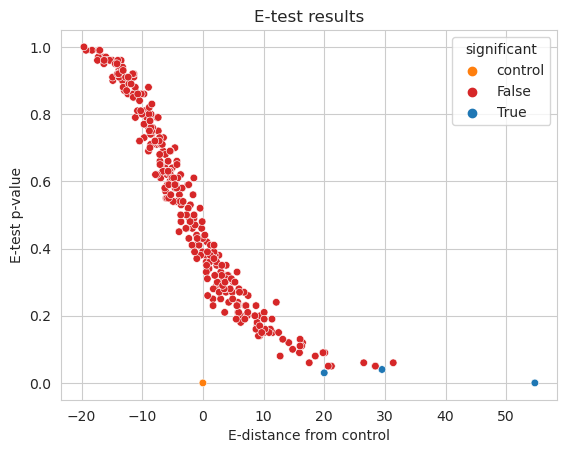

In [25]:
df.loc[df.index=='TuD_NC', 'significant'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue', x='edist', hue='significant', palette={True: 'tab:blue', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test p-value')
pl.show()

### Scatter plot of E-distance from control vs adjusted p-value

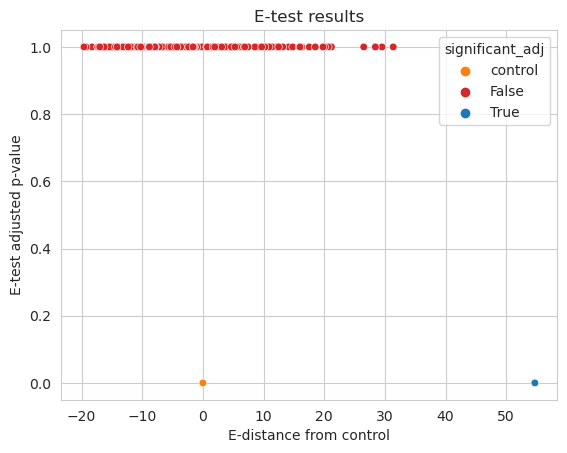

In [26]:
df.loc[df.index=='TuD_NC', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:blue', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

In [27]:
meta2 = sc.get.obs_df(adata, keys = adata.obs.columns.tolist())
meta2

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:GACCTTCTCTTGCAAG-1        miR     43673.0          7535  miR_1   
miR_2:CTGAATGCAGCTGTGC-1        miR     20305.0          5453  miR_2   
miR_2:CCACGTTGTTGGTAGG-1        miR     72601.0          8726  miR_2   
miR_3:TGCAGGCAGTTCACTG-1        miR     56819.0          8345  miR_3   
miR_1:CATGAGTTCGAGCCTG-1        miR     51701.0          7990  miR_1   
...                             ...         ...           ...    ...   
miR_1:GGGACCTTCCAATCCC-1        miR     56217.0          8087  miR_1   
miR_2:TGGATGTTCTCCTGCA-1        miR     36697.0          6379  miR_2   
miR_1:CTACCTGTCGACGAGA-1        miR     42605.0          7583  miR_1   
miR_2:AGGATAATCGCAGTTA-1        miR     38137.0          6405  miR_2   
miR_3:GTGTGGCGTTCCATTT-1        miR     41018.0          6863  miR_3   

                                   barcode        guide       lor  \
miR_1:GACCTTCTCTTGCAAG-1  GACCTTCTCTTGCAAG       TuD_NC  6.635950   
miR_2:CTGAATGCAGCTGTGC-1  CTGAATGCAGCTGTGC       TuD_NC  1.121474   
miR_2:CCACGTTGTTGGTAGG-1  CCACGTTGTTGGTAGG       TuD_NC  4.885842   
miR_3:TGCAGGCAGTTCACTG-1  TGCAGGCAGTTCACTG       TuD_NC  3.509584   
miR_1:CATGAGTTCGAGCCTG-1  CATGAGTTCGAGCCTG       TuD_NC  6.218424   
...                                    ...          ...       ...   
miR_1:GGGACCTTCCAATCCC-1  GGGACCTTCCAATCCC  miR-4742-3p  5.791977   
miR_2:TGGATGTTCTCCTGCA-1  TGGATGTTCTCCTGCA  miR-4742-3p  6.664280   
miR_1:CTACCTGTCGACGAGA-1  CTACCTGTCGACGAGA  miR-4742-3p  6.074720   
miR_2:AGGATAATCGCAGTTA-1  AGGATAATCGCAGTTA  miR-4742-3p  6.441211   
miR_3:GTGTGGCGTTCCATTT-1  GTGTGGCGTTCCATTT  miR-4742-3p  3.380534   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:GACCTTCTCTTGCAAG-1  4.940656e-324  4.986374e-317    171.0  ...   
miR_2:CTGAATGCAGCTGTGC-1   3.714397e-24   3.865853e-17     24.0  ...   
miR_2:CCACGTTGTTGGTAGG-1  4.940656e-324  5.142113e-317    157.0  ...   
miR_3:TGCAGGCAGTTCACTG-1   1.264197e-38   1.012305e-31     39.0  ...   
miR_1:CATGAGTTCGAGCCTG-1  2.465004e-237  2.487814e-230    204.0  ...   
...                                 ...            ...      ...  ...   
miR_1:GGGACCTTCCAATCCC-1  4.940656e-324  4.986374e-317    213.0  ...   
miR_2:TGGATGTTCTCCTGCA-1  1.162270e-279  1.209662e-272    116.0  ...   
miR_1:CTACCTGTCGACGAGA-1  3.922608e-230  3.958905e-223     95.0  ...   
miR_2:AGGATAATCGCAGTTA-1  4.940656e-324  5.142113e-317    135.0  ...   
miR_3:GTGTGGCGTTCCATTT-1  3.889817e-282  3.114767e-275    120.0  ...   

                             m_umi       v_umi  log_max_umi  log_n_umi  \
miR_1:GACCTTCTCTTGCAAG-1  0.586902   73.677404     2.232996   2.367356   
miR_2:CTGAATGCAGCTGTGC-1  0.146096    1.635168     1.380211   1.763428   
miR_2:CCACGTTGTTGGTAGG-1  0.634761   62.353637     2.195900   2.401401   
miR_3:TGCAGGCAGTTCACTG-1  0.259446    3.960296     1.591065   2.012837   
miR_1:CATGAGTTCGAGCCTG-1  0.730479  104.874144     2.309630   2.462398   
...                            ...         ...          ...        ...   
miR_1:GGGACCTTCCAATCCC-1  0.664987  114.374857     2.328380   2.421604   
miR_2:TGGATGTTCTCCTGCA-1  0.397985   33.947269     2.064458   2.198657   
miR_1:CTACCTGTCGACGAGA-1  0.322418   22.779622     1.977724   2.107210   
miR_2:AGGATAATCGCAGTTA-1  0.460957   45.976376     2.130334   2.262451   
miR_3:GTGTGGCGTTCCATTT-1  0.448363   37.283312     2.079181   2.250420   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:GACCTTCTCTTGCAAG-1  -0.231435    4.767247                       3   
miR_2:CTGAATGCAGCTGTGC-1  -0.835363    7.618813                       5   
miR_2:CCACGTTGTTGGTAGG-1  -0.197390    6.728557                       6   
miR_3:TGCAGGCAGTTCACTG-1  -0.585953    8.083564                       1   
miR_1:CATGAGTTCGAGCCTG-1  -0.136393    6.108199                       0   
...                             ...         ...                     ...   
miR_1:GGGACCTTCCAATCCC-1  -0.177187    4.534216     

In [28]:
nn = pd.DataFrame(adata.obsm['X_umap'])

In [29]:
nn3 = pd.DataFrame(adata.obsm['X_pca'])

In [30]:
%%R -i meta2
far_guide_of_interest = 'hsa-miR-193a-5p'
far_guide <- rep('other_miR', nrow(meta2))
far_guide[which(meta2$guide == far_guide_of_interest)] <- far_guide_of_interest
far_guide[which(meta2$guide == 'TuD_NC')] <- 'control'

close_guide_of_interest = 'hsa-miR-128-1-5p'
close_guide <- rep('other_miR', nrow(meta2))
close_guide[which(meta2$guide == close_guide_of_interest)] <- close_guide_of_interest
close_guide[which(meta2$guide == 'TuD_NC')] <- 'control'

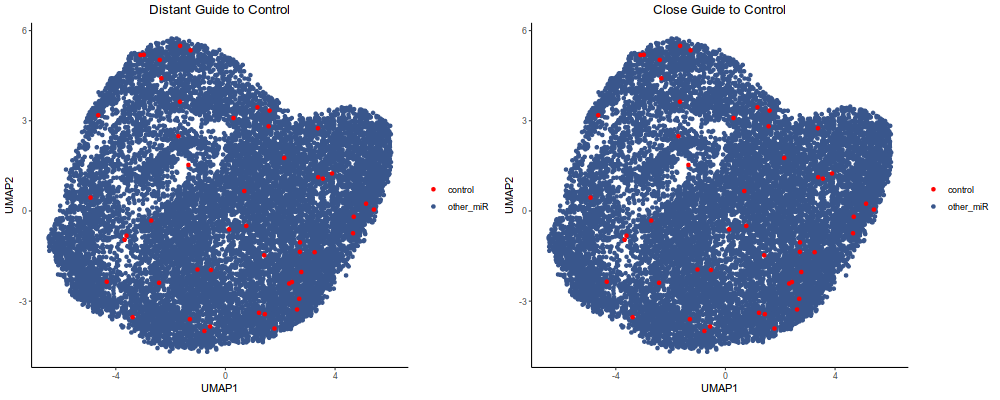

In [31]:
%%R -i nn -h 400 -w 1000

## showing the most distant pertubation to control
library(dplyr)
library(ggpubr)


nn2 = cbind(nn[,1:2], labs = far_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
a <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn2 = cbind(nn[,1:2], labs = close_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
b <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)

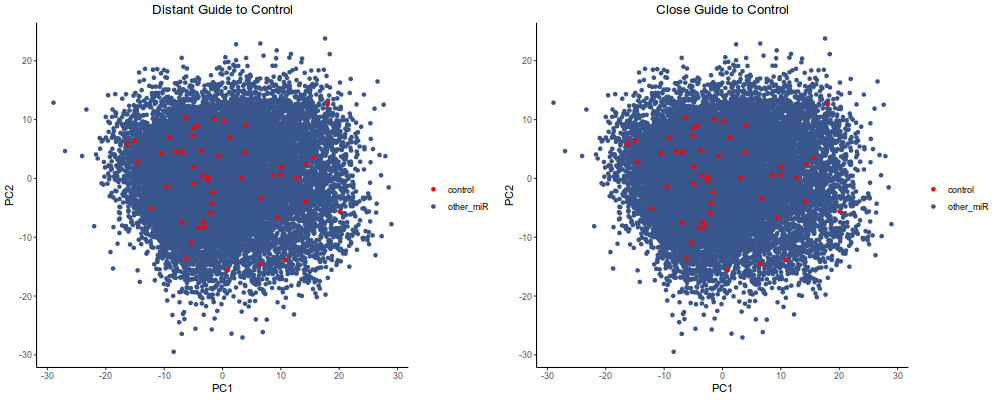

In [32]:
%%R -i nn3 -h 400 -w 1000
## showing the most distant pertubation to control

nn4 = cbind(nn3[,1:2], labs = far_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
a <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn4 = cbind(nn3[,1:2], labs = close_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
b <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)